 # Homework 5


In [61]:
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.ToTensor(),
])


train_set = datasets.CIFAR10('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=True)

test_set = datasets.CIFAR10('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=False)


Files already downloaded and verified
Files already downloaded and verified


In [62]:
train_batch_size = 100
test_batch_size = 10000
epoch_num = 10
lr = 0.2
seed = 50

In [63]:
import torch
from torch.utils.data import DataLoader

device = torch.device('cuda')
print("Using device:", device)
print(torch.__version__)
print(torch.version.cuda)              # Should not be None
print(torch.cuda.is_available())       # Should be True if everything is correct

train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

torch.manual_seed(42)

Using device: cuda
2.5.1
12.4
True


## Experiments

I have tried the following
1. with BatchNorm
2. with BatchNorm + Dropout
3. with BatchNorm + Dropout + l2 regularizer
4. with Dropout + l2 regularizer
5. with BatchNorm + l2 regularizer

Reasoning:
1. I found out that BatchNorm is quite necessary (setup 4 doesn't work), very likely because I did no data preprocessing. 
2. DropOut can smooth the learning curve a lot, but you will loose some overall performance as the tradeoff if the ratio of drop out is too large (say > 0.2).
3. l2 regularizer is the one influence the least. But it can help compare (2) with (3)
4. In setup 2 and 3, if we have more iterations, the test accuracy can grow better. It might mean that there could be a sightly larger learning rate that can allow me achieve better acurracy in 10 epoches.


## Applying BatchNorm

In [64]:
import torch
import torch.nn as nn

model = nn.Sequential(
    
    nn.Conv2d(3, 100, kernel_size=3),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Conv2d(100, 10, kernel_size=5),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(360, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

model = model.to(device)


In [65]:

loss_fn = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []

model.eval()  
test_loss_total = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for test_data, test_targets in test_loader:
        # Move data to device
        test_data = test_data.to(device)
        test_targets = test_targets.to(device)

        # Forward pass using the model
        test_outputs = model(test_data)

        # Compute the loss
        loss = loss_fn(test_outputs, test_targets)
        test_loss_total += loss.item()

        # Compute accuracy
        predictions = torch.argmax(test_outputs, dim=1)
        correct_predictions += (predictions == test_targets).sum().item()
        total_samples += test_targets.size(0)

avg_test_loss = test_loss_total / len(test_loader)
accuracy = correct_predictions / total_samples

print(f'Epoch {0} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')

losses.append(avg_test_loss)
accuracies.append(accuracy)

for epoch in range(epoch_num):   

    model.train()  
    for batch_data, batch_targets in train_loader:
        # Move the batch to device
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)
        
        # zero out gradients for all model parameters
        for param in model.parameters():
            if param.grad is not None:
                param.grad = None
        
        # Forward pass
        outputs = model(batch_data)
        
        # Compute loss
        loss = loss_fn(outputs, batch_targets)
        
        # Backward Propagate
        loss.backward()

        # grad_norm = model[0].weight.grad.norm().item()
        # print(f"Gradient norm (first conv layer): {grad_norm}")
        
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
    

    model.eval()  
    test_loss_total = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for test_data, test_targets in test_loader:
            # Move data to device
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Forward pass using the model
            test_outputs = model(test_data)

            # Compute the loss
            loss = loss_fn(test_outputs, test_targets)
            test_loss_total += loss.item()

            # Compute accuracy
            predictions = torch.argmax(test_outputs, dim=1)
            correct_predictions += (predictions == test_targets).sum().item()
            total_samples += test_targets.size(0)
    
    avg_test_loss = test_loss_total / len(test_loader)
    accuracy = correct_predictions / total_samples

    print(f'Epoch {epoch + 1} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')
    
    losses.append(avg_test_loss)
    accuracies.append(accuracy)

Epoch 0 | Test Loss: 2.304880142211914, Test Accuracy: 0.1
Epoch 1 | Test Loss: 2.0177090167999268, Test Accuracy: 0.3709
Epoch 2 | Test Loss: 1.3331446647644043, Test Accuracy: 0.5122
Epoch 3 | Test Loss: 1.540727972984314, Test Accuracy: 0.4919
Epoch 4 | Test Loss: 1.122189998626709, Test Accuracy: 0.6269
Epoch 5 | Test Loss: 1.0445733070373535, Test Accuracy: 0.6517
Epoch 6 | Test Loss: 0.8741851449012756, Test Accuracy: 0.6959
Epoch 7 | Test Loss: 1.2315527200698853, Test Accuracy: 0.6093
Epoch 8 | Test Loss: 0.7102081179618835, Test Accuracy: 0.7604
Epoch 9 | Test Loss: 0.7757323980331421, Test Accuracy: 0.7374
Epoch 10 | Test Loss: 0.7727534174919128, Test Accuracy: 0.7375


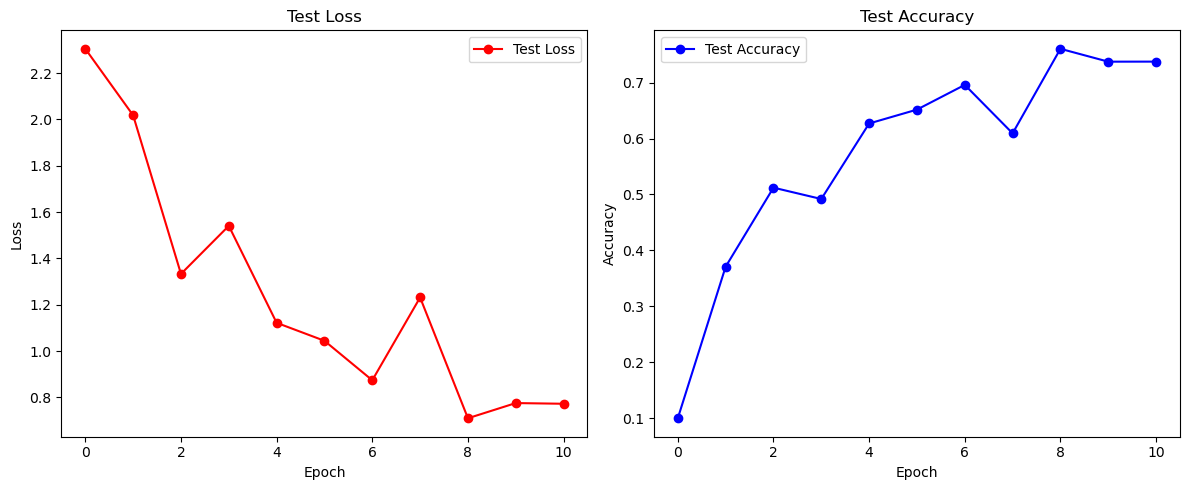

In [68]:
import matplotlib.pyplot as plt

epochs = range(0, epoch_num + 1)

plt.figure(figsize=(12, 5))

# 1) Plot the test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'r-o', label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2) Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b-o', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Applying BatchNorm + dropouts & Larger LR
lr = 0.8

In [87]:
lr = 0.5

import torch
import torch.nn as nn

model = nn.Sequential(
    
    nn.Conv2d(3, 100, kernel_size=3),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 10, kernel_size=5),
    nn.BatchNorm2d(10),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(360, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    # nn.Dropout1d(0.2),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    # nn.Dropout1d(0.2),
    nn.Linear(64, 10),
)

model = model.to(device)


loss_fn = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []


model.eval()  
test_loss_total = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for test_data, test_targets in test_loader:
        # Move data to device
        test_data = test_data.to(device)
        test_targets = test_targets.to(device)

        # Forward pass using the model
        test_outputs = model(test_data)

        # Compute the loss
        loss = loss_fn(test_outputs, test_targets)
        test_loss_total += loss.item()

        # Compute accuracy
        predictions = torch.argmax(test_outputs, dim=1)
        correct_predictions += (predictions == test_targets).sum().item()
        total_samples += test_targets.size(0)

avg_test_loss = test_loss_total / len(test_loader)
accuracy = correct_predictions / total_samples

print(f'Epoch {0} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')

losses.append(avg_test_loss)
accuracies.append(accuracy)


for epoch in range(epoch_num):

    model.train()  
    for batch_data, batch_targets in train_loader:
        # Move the batch to device
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)
        
        # zero out gradients for all model parameters
        for param in model.parameters():
            if param.grad is not None:
                param.grad = None
        
        # Forward pass
        outputs = model(batch_data)
        
        # Compute loss
        loss = loss_fn(outputs, batch_targets)
        
        # Backward Propagate
        loss.backward()

        # grad_norm = model[0].weight.grad.norm().item()
        # print(f"Gradient norm (first conv layer): {grad_norm}")
        
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
    
    model.eval()  
    test_loss_total = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for test_data, test_targets in test_loader:
            # Move data to device
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Forward pass using the model
            test_outputs = model(test_data)

            # Compute the loss
            loss = loss_fn(test_outputs, test_targets)
            test_loss_total += loss.item()

            # Compute accuracy
            predictions = torch.argmax(test_outputs, dim=1)
            correct_predictions += (predictions == test_targets).sum().item()
            total_samples += test_targets.size(0)
    
    avg_test_loss = test_loss_total / len(test_loader)
    accuracy = correct_predictions / total_samples

    print(f'Epoch {epoch + 1} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')
    
    losses.append(avg_test_loss)
    accuracies.append(accuracy)

Epoch 0 | Test Loss: 2.30465030670166, Test Accuracy: 0.1
Epoch 1 | Test Loss: 2.0061802864074707, Test Accuracy: 0.3047
Epoch 2 | Test Loss: 1.3513866662979126, Test Accuracy: 0.5044
Epoch 3 | Test Loss: 1.2221609354019165, Test Accuracy: 0.5651
Epoch 4 | Test Loss: 1.0770224332809448, Test Accuracy: 0.6198
Epoch 5 | Test Loss: 1.0749516487121582, Test Accuracy: 0.6092
Epoch 6 | Test Loss: 0.9287683367729187, Test Accuracy: 0.6715
Epoch 7 | Test Loss: 0.8611786961555481, Test Accuracy: 0.6983
Epoch 8 | Test Loss: 0.871141791343689, Test Accuracy: 0.6957
Epoch 9 | Test Loss: 0.778343141078949, Test Accuracy: 0.7272
Epoch 10 | Test Loss: 0.7227872610092163, Test Accuracy: 0.7505


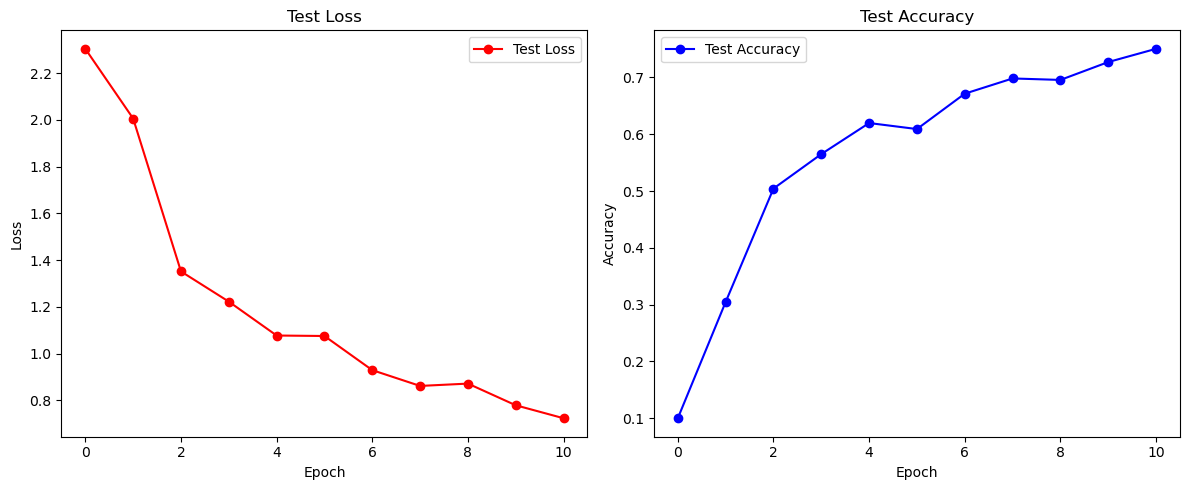

In [88]:
import matplotlib.pyplot as plt

epochs = range(0, epoch_num + 1)

plt.figure(figsize=(12, 5))

# 1) Plot the test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'r-o', label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2) Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b-o', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## BatchNorm + Dropout + l2-Regularization

In [78]:
lr = 0.5
l2_lambda = 1e-4

import torch
import torch.nn as nn

model = nn.Sequential(
    
    nn.Conv2d(3, 100, kernel_size=3),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    # nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    # nn.Dropout2d(0.1),
    nn.Conv2d(100, 10, kernel_size=5),
    nn.BatchNorm2d(10),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(360, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    # nn.Dropout1d(0.2),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    # nn.Dropout1d(0.2),
    nn.Linear(64, 10),
)

model = model.to(device)


loss_fn = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []


model.eval()  
test_loss_total = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for test_data, test_targets in test_loader:
        # Move data to device
        test_data = test_data.to(device)
        test_targets = test_targets.to(device)

        # Forward pass using the model
        test_outputs = model(test_data)

        # Compute the loss
        loss = loss_fn(test_outputs, test_targets)
        test_loss_total += loss.item()

        # Compute accuracy
        predictions = torch.argmax(test_outputs, dim=1)
        correct_predictions += (predictions == test_targets).sum().item()
        total_samples += test_targets.size(0)

avg_test_loss = test_loss_total / len(test_loader)
accuracy = correct_predictions / total_samples

print(f'Epoch {0} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')

losses.append(avg_test_loss)
accuracies.append(accuracy)


for epoch in range(epoch_num):

    model.train()  
    for batch_data, batch_targets in train_loader:
        # Move the batch to device
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)
        
        # zero out gradients for all model parameters
        for param in model.parameters():
            if param.grad is not None:
                param.grad = None
        
        # Forward pass
        outputs = model(batch_data)
        
        # Compute loss
        l2_norm = sum(param.pow(2.0).sum() 
                      for name, param in model.named_parameters() 
                      if "bias" not in name)
        loss = loss_fn(outputs, batch_targets) + l2_norm * l2_lambda
        
        # Backward Propagate
        loss.backward()

        # grad_norm = model[0].weight.grad.norm().item()
        # print(f"Gradient norm (first conv layer): {grad_norm}")
        
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
    
    model.eval()  
    test_loss_total = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for test_data, test_targets in test_loader:
            # Move data to device
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Forward pass using the model
            test_outputs = model(test_data)

            # Compute the loss
            
            loss = loss_fn(test_outputs, test_targets)
            test_loss_total += loss.item() 

            # Compute accuracy
            predictions = torch.argmax(test_outputs, dim=1)
            correct_predictions += (predictions == test_targets).sum().item()
            total_samples += test_targets.size(0)
    
    avg_test_loss = test_loss_total / len(test_loader)
    accuracy = correct_predictions / total_samples

    print(f'Epoch {epoch + 1} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')
    
    losses.append(avg_test_loss)
    accuracies.append(accuracy)

Epoch 0 | Test Loss: 2.303917169570923, Test Accuracy: 0.1
Epoch 1 | Test Loss: 1.5325266122817993, Test Accuracy: 0.434
Epoch 2 | Test Loss: 1.3643617630004883, Test Accuracy: 0.5118
Epoch 3 | Test Loss: 1.2243926525115967, Test Accuracy: 0.5539
Epoch 4 | Test Loss: 1.0788793563842773, Test Accuracy: 0.6187
Epoch 5 | Test Loss: 1.0872890949249268, Test Accuracy: 0.6154
Epoch 6 | Test Loss: 1.0149242877960205, Test Accuracy: 0.6501
Epoch 7 | Test Loss: 0.8753826022148132, Test Accuracy: 0.6945
Epoch 8 | Test Loss: 0.8763338923454285, Test Accuracy: 0.6927
Epoch 9 | Test Loss: 0.7869715094566345, Test Accuracy: 0.722
Epoch 10 | Test Loss: 0.7388575673103333, Test Accuracy: 0.7459


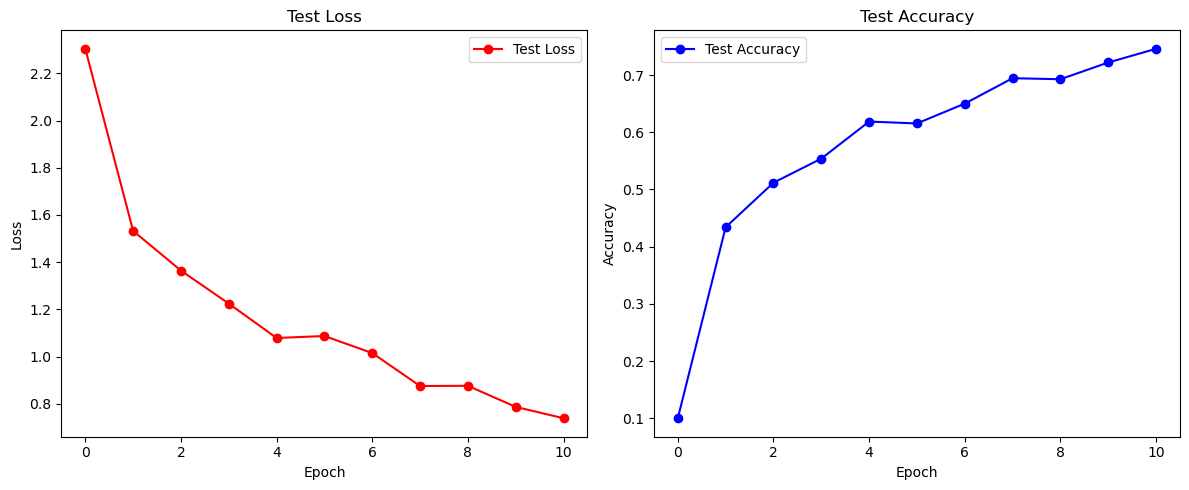

In [79]:
import matplotlib.pyplot as plt

epochs = range(0, epoch_num + 1)

plt.figure(figsize=(12, 5))

# 1) Plot the test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'r-o', label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2) Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b-o', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Applying Dropout + l2 regularization, no BatchNorm
 This obviously doesn't work since we don't normalize our input

In [81]:
lr = 0.5
l2_lambda = 1e-4

import torch
import torch.nn as nn

model = nn.Sequential(
    
    nn.Conv2d(3, 100, kernel_size=3),

    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),

    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),

    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),

    nn.ReLU(),
    nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),

    nn.ReLU(),
    # nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),

    nn.ReLU(),
    # nn.Dropout2d(0.1),
    nn.Conv2d(100, 10, kernel_size=5),

    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(360, 128),

    nn.ReLU(),
    # nn.Dropout1d(0.2),
    nn.Linear(128, 64),

    nn.ReLU(),
    # nn.Dropout1d(0.2),
    nn.Linear(64, 10),
)

model = model.to(device)


loss_fn = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []


model.eval()  
test_loss_total = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for test_data, test_targets in test_loader:
        # Move data to device
        test_data = test_data.to(device)
        test_targets = test_targets.to(device)

        # Forward pass using the model
        test_outputs = model(test_data)

        # Compute the loss
        loss = loss_fn(test_outputs, test_targets)
        test_loss_total += loss.item()

        # Compute accuracy
        predictions = torch.argmax(test_outputs, dim=1)
        correct_predictions += (predictions == test_targets).sum().item()
        total_samples += test_targets.size(0)

avg_test_loss = test_loss_total / len(test_loader)
accuracy = correct_predictions / total_samples

print(f'Epoch {0} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')

losses.append(avg_test_loss)
accuracies.append(accuracy)


for epoch in range(epoch_num):

    model.train()  
    for batch_data, batch_targets in train_loader:
        # Move the batch to device
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)
        
        # zero out gradients for all model parameters
        for param in model.parameters():
            if param.grad is not None:
                param.grad = None
        
        # Forward pass
        outputs = model(batch_data)
        
        # Compute loss
        l2_norm = sum(param.pow(2.0).sum() 
                      for name, param in model.named_parameters() 
                      if "bias" not in name)
        loss = loss_fn(outputs, batch_targets) + l2_norm * l2_lambda
        
        # Backward Propagate
        loss.backward()

        # grad_norm = model[0].weight.grad.norm().item()
        # print(f"Gradient norm (first conv layer): {grad_norm}")
        
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
    
    model.eval()  
    test_loss_total = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for test_data, test_targets in test_loader:
            # Move data to device
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Forward pass using the model
            test_outputs = model(test_data)

            # Compute the loss
            
            loss = loss_fn(test_outputs, test_targets)
            test_loss_total += loss.item() 

            # Compute accuracy
            predictions = torch.argmax(test_outputs, dim=1)
            correct_predictions += (predictions == test_targets).sum().item()
            total_samples += test_targets.size(0)
    
    avg_test_loss = test_loss_total / len(test_loader)
    accuracy = correct_predictions / total_samples

    print(f'Epoch {epoch + 1} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')
    
    losses.append(avg_test_loss)
    accuracies.append(accuracy)

Epoch 0 | Test Loss: 2.3062856197357178, Test Accuracy: 0.1
Epoch 1 | Test Loss: 2.304871082305908, Test Accuracy: 0.1
Epoch 2 | Test Loss: 2.3037850856781006, Test Accuracy: 0.1
Epoch 3 | Test Loss: 2.305027723312378, Test Accuracy: 0.1
Epoch 4 | Test Loss: 2.3038041591644287, Test Accuracy: 0.1
Epoch 5 | Test Loss: 2.3039960861206055, Test Accuracy: 0.1
Epoch 6 | Test Loss: 2.3045918941497803, Test Accuracy: 0.1
Epoch 7 | Test Loss: 2.3037455081939697, Test Accuracy: 0.1
Epoch 8 | Test Loss: 2.3035483360290527, Test Accuracy: 0.1
Epoch 9 | Test Loss: 2.302855968475342, Test Accuracy: 0.1
Epoch 10 | Test Loss: 2.303161859512329, Test Accuracy: 0.1


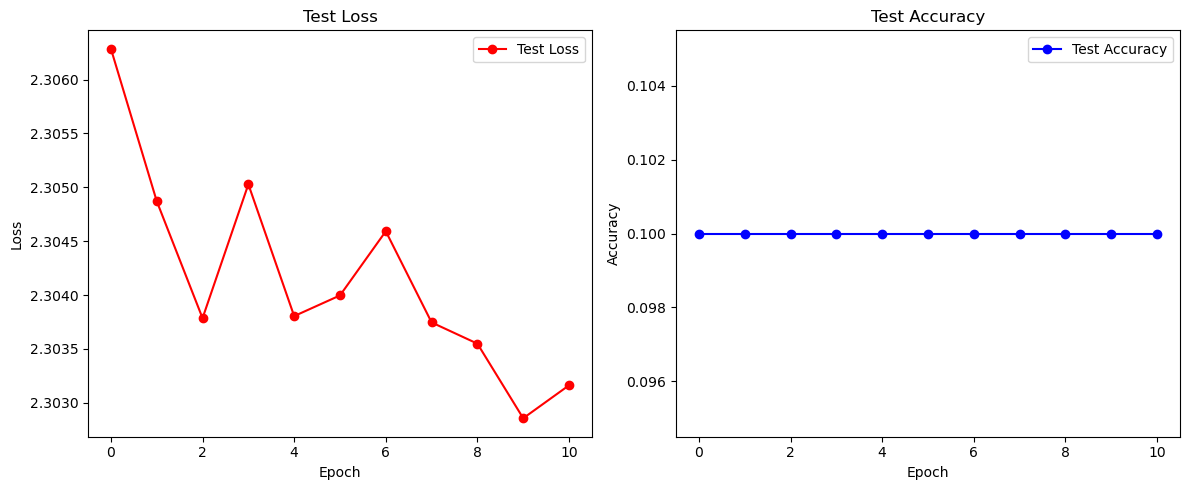

In [82]:
import matplotlib.pyplot as plt

epochs = range(0, epoch_num + 1)

plt.figure(figsize=(12, 5))

# 1) Plot the test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'r-o', label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2) Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b-o', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## BatchNorm + l2 Reg

In [83]:
lr = 0.5
l2_lambda = 1e-4

import torch
import torch.nn as nn

model = nn.Sequential(
    
    nn.Conv2d(3, 100, kernel_size=3),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    # nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    # nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    # nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    # nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    # nn.Dropout2d(0.1),
    nn.Conv2d(100, 100, kernel_size=5),
    nn.BatchNorm2d(100),
    nn.ReLU(),
    # nn.Dropout2d(0.1),
    nn.Conv2d(100, 10, kernel_size=5),
    nn.BatchNorm2d(10),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(360, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    # nn.Dropout1d(0.2),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    # nn.Dropout1d(0.2),
    nn.Linear(64, 10),
)

model = model.to(device)


loss_fn = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []


model.eval()  
test_loss_total = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for test_data, test_targets in test_loader:
        # Move data to device
        test_data = test_data.to(device)
        test_targets = test_targets.to(device)

        # Forward pass using the model
        test_outputs = model(test_data)

        # Compute the loss
        loss = loss_fn(test_outputs, test_targets)
        test_loss_total += loss.item()

        # Compute accuracy
        predictions = torch.argmax(test_outputs, dim=1)
        correct_predictions += (predictions == test_targets).sum().item()
        total_samples += test_targets.size(0)

avg_test_loss = test_loss_total / len(test_loader)
accuracy = correct_predictions / total_samples

print(f'Epoch {0} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')

losses.append(avg_test_loss)
accuracies.append(accuracy)


for epoch in range(epoch_num):

    model.train()  
    for batch_data, batch_targets in train_loader:
        # Move the batch to device
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)
        
        # zero out gradients for all model parameters
        for param in model.parameters():
            if param.grad is not None:
                param.grad = None
        
        # Forward pass
        outputs = model(batch_data)
        
        # Compute loss
        l2_norm = sum(param.pow(2.0).sum() 
                      for name, param in model.named_parameters() 
                      if "bias" not in name)
        loss = loss_fn(outputs, batch_targets) + l2_norm * l2_lambda
        
        # Backward Propagate
        loss.backward()

        # grad_norm = model[0].weight.grad.norm().item()
        # print(f"Gradient norm (first conv layer): {grad_norm}")
        
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
    
    model.eval()  
    test_loss_total = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for test_data, test_targets in test_loader:
            # Move data to device
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Forward pass using the model
            test_outputs = model(test_data)

            # Compute the loss
            
            loss = loss_fn(test_outputs, test_targets)
            test_loss_total += loss.item() 

            # Compute accuracy
            predictions = torch.argmax(test_outputs, dim=1)
            correct_predictions += (predictions == test_targets).sum().item()
            total_samples += test_targets.size(0)
    
    avg_test_loss = test_loss_total / len(test_loader)
    accuracy = correct_predictions / total_samples

    print(f'Epoch {epoch + 1} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')
    
    losses.append(avg_test_loss)
    accuracies.append(accuracy)

Epoch 0 | Test Loss: 2.3050572872161865, Test Accuracy: 0.1
Epoch 1 | Test Loss: 1.6066546440124512, Test Accuracy: 0.4132
Epoch 2 | Test Loss: 1.4491676092147827, Test Accuracy: 0.5151
Epoch 3 | Test Loss: 1.1045273542404175, Test Accuracy: 0.6078
Epoch 4 | Test Loss: 1.2709892988204956, Test Accuracy: 0.5385
Epoch 5 | Test Loss: 0.8289772272109985, Test Accuracy: 0.7122
Epoch 6 | Test Loss: 1.015119194984436, Test Accuracy: 0.659
Epoch 7 | Test Loss: 1.0191761255264282, Test Accuracy: 0.6499
Epoch 8 | Test Loss: 0.8245769739151001, Test Accuracy: 0.7167
Epoch 9 | Test Loss: 0.7992412447929382, Test Accuracy: 0.7347
Epoch 10 | Test Loss: 0.7357098460197449, Test Accuracy: 0.7509


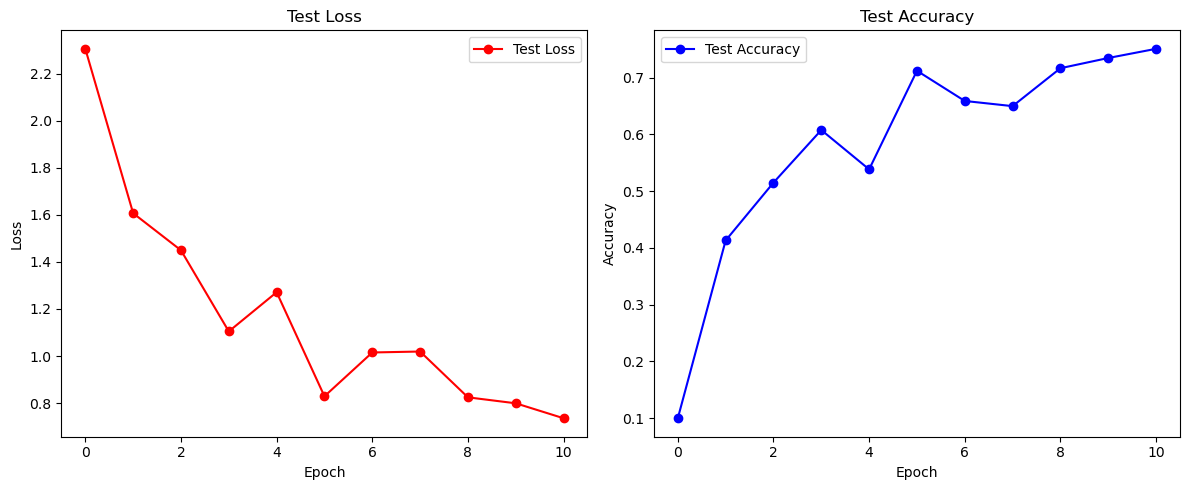

In [84]:
import matplotlib.pyplot as plt

epochs = range(0, epoch_num + 1)

plt.figure(figsize=(12, 5))

# 1) Plot the test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'r-o', label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2) Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b-o', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Manual conv2d layers, too slow

In [4]:
def linear_relu(W, B, x):
    g = x @ W.T + B
    return torch.max(g, torch.tensor(0.0, device=x.device))

def linear(W, B, x):
    g = x @ W.T + B
    return g

# def conv2d_relu(W, B, x):
#     C_out, C_in, k, _ = W.shape
#     N, C_in_x, H, W_x = x.shape

#     assert C_in == C_in_x

#     H_out = H - k + 1
#     W_out = W_x - k + 1

#     g = torch.zeros((N, C_out, H_out, W_out), device=x.device, dtype=x.dtype)

#     for n in range(N):
#         for c_out in range(C_out):
#             for i in range(H_out):
#                 for j in range(W_out):
#                     region = x[n, :, i:i+k, j:j+k]
#                     g[n, c_out, i, j] = region.flatten() @ W[c_out].flatten() + B[c_out]
                    
#     return torch.max(g, torch.tensor(0.0, device=x.device))



def conv2d_relu(W, B, x):
    N, C_in, H, W_in = x.shape
    C_out, C_in_W, k, _ = W.shape

    H_out = H - k + 1
    W_out = W_in - k + 1

    W_flat = W.reshape(C_out, -1)
    outputs = []

    for n in range(N):
        x_n = x[n:n+1]
        x_unf = x_n.unfold(2, k, 1).unfold(3, k, 1)
        x_cols = x_unf.permute(0, 2, 3, 1, 4, 5).reshape(1, H_out * W_out, -1)
        g = torch.matmul(x_cols, W_flat.t())
        g = g + B.view(1, 1, C_out)
        g = g.view(1, H_out, W_out, C_out).permute(0, 3, 1, 2)
        outputs.append(torch.max(g, torch.tensor(0.0, device=x.device)))
        
    return torch.cat(outputs, dim=0)


def layer_norm(h, epsilon=1e-6):
    return (h - torch.mean(input=h, dim=1, keepdim=True))/(torch.std(input=h, dim=1, keepdim=True) + epsilon)

def initialize_weight_bias_conv2(in_channels, out_channels, kernel_size, device):
    W = torch.empty(out_channels, in_channels, kernel_size, kernel_size, device=device, requires_grad=True)
    torch.nn.init.kaiming_normal_(W)
    
    B = torch.zeros(out_channels, device=device, requires_grad=True)

    return W, B

def initialize_weight_bias_linear(out_size, in_size, device):
    W = torch.empty(out_size, in_size, device=device, requires_grad=True)
    torch.nn.init.kaiming_normal_(W)

    B = torch.zeros(out_size, device=device, requires_grad=True)

    return W, B


In [5]:
conv_W_list = []
conv_B_list = []
linear_W_list = []
linear_B_list = []

conv_layer_dims = [(3, 100, 3), (100, 100, 5), (100, 100, 5), (100, 100, 5), (100, 100, 5), (100, 100, 5), (100, 10, 5)]
linear_layer_dims = [(360, 128), (128,64), (64, 10)]


for in_channels, out_channels, kernel_size in conv_layer_dims:
    W, B = initialize_weight_bias_conv2(in_channels, out_channels, kernel_size, device)
    conv_W_list.append(W)
    conv_B_list.append(B)

linear_layer_dims = [(360, 128), (128, 64), (64, 10)]
for in_size, out_size in linear_layer_dims:
    W, B = initialize_weight_bias_linear(out_size, in_size, device)
    linear_W_list.append(W)
    linear_B_list.append(B)


print(f"Initialized {len(conv_W_list)} Conv2D layers")
print(f"Initialized {len(linear_W_list)} Linear layers")


Initialized 7 Conv2D layers
Initialized 3 Linear layers


In [6]:
def nn_forward(conv_W_list, conv_B_list, linear_W_list, linear_B_list, x):
    output = x
    for i in range(len(conv_W_list)):
        output = conv2d_relu(conv_W_list[i], conv_B_list[i], output)
    output = torch.flatten(output, start_dim = 1)
    for i in range(len(linear_W_list) - 1):
        output = linear_relu(linear_W_list[i], linear_B_list[i], output)
    output = linear(linear_W_list[-1], linear_B_list[-1], output)

    return output

    

In [7]:
losses = []
accuracies = []

for epoch in range(epoch_num):
    # Compute the test loss and accuracy in the beginning of each epoch
    test_loss_total = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for test_data, test_targets in test_loader:
            # Move the tensors to GPU
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            test_res = nn_forward(conv_W_list, conv_B_list, linear_W_list, linear_B_list, test_data)

            # Compute the loss
            cross_entropy_loss = torch.nn.CrossEntropyLoss()
            loss = cross_entropy_loss(test_res, test_targets)
            test_loss_total += loss.item()

            # Compute the accuracy
            predictions = torch.argmax(test_res, dim=1)
            correct_predictions += (predictions == test_targets).sum().item()
            total_samples += test_targets.size(0)
    
    avg_test_loss = test_loss_total / len(test_loader) # average loss for one batch
    accuracy = correct_predictions/total_samples

    print(f'Epoch {epoch + 1} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')

    losses.append(avg_test_loss)
    accuracies.append(accuracy)

     # Training
    for batch_data, batch_targets in train_loader:

        # Move the batch to GPU
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)

        for conv_W in conv_W_list:
            conv_W.grad = None
        for conv_B in conv_B_list:
            conv_B.grad = None
        for linear_W in linear_W_list:
            linear_W.grad = None
        for linear_B in linear_B_list:
            linear_B.grad = None
        
        output = nn_forward(conv_W_list, conv_B_list, linear_W_list, linear_B_list, batch_data)

        # Loss computing
        cross_entropy_loss = torch.nn.CrossEntropyLoss()
        target = batch_targets
        loss = cross_entropy_loss(output, target)
        loss.backward()

         # Back Propagate
        with torch.no_grad():
            for conv_W in conv_W_list:
                conv_W -= lr * conv_W.grad
            for conv_B in conv_B_list:
                conv_B -= lr * conv_B.grad
            for linear_W in linear_W_list:
                linear_W -= lr * linear_W.grad
            for linear_B in linear_B_list:
                linear_B -= lr * linear_B.grad

Epoch 1 | Test Loss: 2.501610255241394, Test Accuracy: 0.1066
Epoch 2 | Test Loss: 2.2661070346832277, Test Accuracy: 0.1317
Epoch 3 | Test Loss: 1.9006613612174987, Test Accuracy: 0.3134
Epoch 4 | Test Loss: 1.77671560049057, Test Accuracy: 0.3474


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, epoch_num + 1)

plt.figure(figsize=(12, 5))

# 1) Plot the test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'r-o', label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2) Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b-o', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()